In [0]:
# take care of all imports here
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, LSTM, SpatialDropout1D
from keras.utils import to_categorical
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Question 1

In [0]:
from tensorboardcolab import *
from __future__ import print_function
import os
from datetime import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from sklearn.model_selection import train_test_split

tbc=TensorBoardColab()
df = pd.read_csv('Boston.csv')
kc_data = pd.DataFrame(df, columns=["crim","zn","indus","chas","nox","rm","age","dis","rad","tax","ptratio","lstat","medv"])
label_col = 'medv'
#print(kc_data.describe())
kc_x_train, kc_x_valid, kc_y_train, kc_y_valid = train_test_split(kc_data.iloc[:,0:12], kc_data.iloc[:,12],
                                                    test_size=0.3, random_state=87)

np.random.seed(155)
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

def z_score(col, stats):
    m, M, mu, s = stats
    df2 = pd.DataFrame()
    for c in col.columns:
        df2[c] = (col[c]-mu[c])/s[c]
    return df2

stats = norm_stats(kc_x_train, kc_x_valid)
arr_x_train = np.array(z_score(kc_x_train, stats))
arr_y_train = np.array(kc_y_train)
arr_x_valid = np.array(z_score(kc_x_valid, stats))
arr_y_valid = np.array(kc_y_valid)
print('Training shape:', arr_x_train.shape)
print('ddd',arr_y_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

#basic_model_1 created model with some parameters
def basic_model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(y_size))
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    return(t_model)

#basic_model_2 is different from basic_model_1 but doing the same task with different structure
def basic_model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", input_shape=(x_size,)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu"))
    t_model.add(Dense(20, activation="relu"))
    t_model.add(Dense(y_size))
    keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    t_model.compile(loss='mean_squared_error',
        optimizer=Adam(),
        metrics=[metrics.mae])
    tensorboard = TensorBoard(log_dir="logs/final1",histogram_freq=0, write_graph=True, write_images=True)
    return(t_model)

model = basic_model_2(arr_x_train.shape[1], 1)

model.summary()
epochs = 20
batch_size =32
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),callbacks=[TensorBoardColabCallback(tbc)])

train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4))
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

keras_callbacks = [
    ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2),
    ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0),
    TensorBoard(log_dir='./model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)

    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

 # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

Wait for 8 seconds...
TensorBoard link:
https://10a2dc48.ngrok.io


FileNotFoundError: ignored

### Question 2

In [0]:
from keras import optimizers
import keras
import keras.utils
from keras import utils as np_utils
from sklearn import preprocessing
df = pd.read_csv('Heart.csv')
x = df[df.columns[:12]]
y = df.target
x_train, x_test, y_train, y_test = train_test_split(x, y , train_size = 0.7, random_state =  90)
#Select numerical columns which needs to be normalized
train_norm = x_train[['age','trestbps','chol','thalach']]
test_norm = x_test[['age','trestbps','chol','thalach']]
#.loc(['age','trestbps','chol','thalach'])
# Normalize Training Data
std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns)
x_train.update(training_norm_col)
print (x_train.head())
# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns)
x_test.update(testing_norm_col)
print (x_train.head())

from tensorboardcolab import *
tbc=TensorBoardColab()
#Build neural network model with normalized data
model = keras.Sequential([
 keras.layers.Dense(64, activation=tf.nn.relu,
 input_shape=(x_train.shape[1],)),
 keras.layers.Dense(64, activation=tf.nn.relu),
 keras.layers.Dense(8, activation=  'softmax')
 ])

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2 = model.fit(
 x_train, y_train,
 epochs= 26, batch_size = 60,
 validation_data = (x_test, y_test),callbacks=[TensorBoardColabCallback(tbc)])
score=model.evaluate(x_test,y_test)
print('test accuracy',score[1])


# changing hyperparameters

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history2 = model.fit(
 x_train, y_train,
 epochs= 50, batch_size = 128,
 validation_data = (x_test, y_test),callbacks=[TensorBoardColabCallback(tbc)])

### Question 3

In [0]:
directory = 'drive/My Drive/DeepLearning Lab 2 Data Sets/training/training/%s'
# setting up a dictionary of labels since the data doesn't come prelabeled
labels = {
    'n0': 'alouatta_palliata',
    'n1': 'erythrocebus_patas',
    'n2': 'cacajao_calvus',
    'n3': 'macaca_fuscata',
    'n4': 'cebuella_pygmea',
    'n5': 'cebus_capucinus',
    'n6': 'mico_argentatus',
    'n7': 'saimiri_sciureus',
    'n8': 'aotus_nigriceps',
    'n9': 'nilgiri_langur'
}

y_labels = []
x_images = []

# iterate through all of the keys in the label dictionary and read in the images from that specific directory
# then load their labels in-order
for folder in labels.keys():
    for filename in os.listdir('drive/My Drive/DeepLearning Lab 2 Data Sets/training/training/%s' % folder):
        imgpath = (directory % folder) + '/' + filename
        img = image.load_img(imgpath, target_size=(32, 32, 3))
        img = image.img_to_array(img)
        img = img / 255
        y_labels.append(labels[folder])
        x_images.append(img)

x = np.array(x_images)


Train on 878 samples, validate on 220 samples
Epoch 1/20
878/878 [==============================] - 4s 4ms/step - loss: 2.2783 - acc: 0.1298 - val_loss: 2.1919 - val_acc: 0.2818
Epoch 2/20
878/878 [==============================] - 0s 183us/step - loss: 2.1305 - acc: 0.2267 - val_loss: 2.0888 - val_acc: 0.3091
Epoch 3/20
878/878 [==============================] - 0s 172us/step - loss: 2.0099 - acc: 0.2756 - val_loss: 1.9273 - val_acc: 0.3364
Epoch 4/20
878/878 [==============================] - 0s 174us/step - loss: 1.9240 - acc: 0.2984 - val_loss: 2.0327 - val_acc: 0.3091
Epoch 5/20
878/878 [==============================] - 0s 188us/step - loss: 1.8907 - acc: 0.3462 - val_loss: 1.8041 - val_acc: 0.3727
Epoch 6/20
878/878 [==============================] - 0s 186us/step - loss: 1.6626 - acc: 0.4248 - val_loss: 1.6450 - val_acc: 0.4545
Epoch 7/20
878/878 [==============================] - 0s 166us/step - loss: 1.5652 - acc: 0.4624 - val_loss: 1.4770 - val_acc: 0.5045
Epoch 8/20
878/87

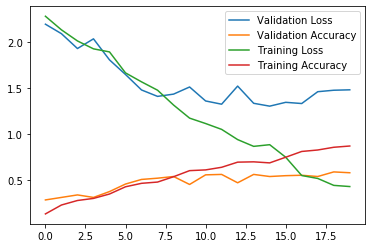

In [0]:
# encoded the categories as numeric values
le = preprocessing.LabelEncoder()
le.fit(y_labels)
y = np_utils.to_categorical(le.transform(y_labels))

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

# define the model structure
# this structure was choosen for performance reasons so that it wouldn't take a long time to execute
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(32,32,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# setting hyper parameters for the model (learning rate, momentum, decay and epochs)
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

# use the sgd as the optimizer and compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
imag_class_hist = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

metrics = imag_class_hist.history
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.plot(metrics['val_acc'], label="Validation Accuracy")
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['acc'], label="Training Accuracy")
plt.legend()
plt.show()

In [0]:
# load in the validation data the same as we did for the training data
validation_directory = 'drive/My Drive/DeepLearning Lab 2 Data Sets/validation/validation/%s'
validation_y_labels = []
validation_x_images = []
for folder in labels.keys():
    for filename in os.listdir(validation_directory % folder):
        imgpath = (validation_directory % folder) + '/' + filename
        img = image.load_img(imgpath, target_size=(32, 32, 3))
        img = image.img_to_array(img)
        img = img / 255
        validation_y_labels.append(labels[folder])
        validation_x_images.append(img)

In [0]:
# categorize the labels for the images
validation_x = np.array(validation_x_images)
validation_y = np_utils.to_categorical(le.transform(validation_y_labels))

# run the images through the prediction model and print the results
predictions = model.predict_classes(validation_x)
for indx, pred in enumerate(predictions):
    print("Predicted value: %s ------> Actual value: %s" % (labels['n%s' % pred], validation_y_labels[indx]))

Predicted value: nilgiri_langur ------> Actual value: alouatta_palliata
Predicted value: aotus_nigriceps ------> Actual value: alouatta_palliata
Predicted value: aotus_nigriceps ------> Actual value: alouatta_palliata
Predicted value: aotus_nigriceps ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata ------> Actual value: alouatta_palliata
Predicted value: mico_argentatus ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata ------> Actual value: alouatta_palliata
Predicted value: aotus_nigriceps ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata ------> Actual value: alouatta_palliata
Predicted value: mico_argentatus ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata ------> Actual value: alouatta_palliata
Predicted value: alouatta_palliata -----

### Question 4

In [0]:
import re
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
import matplotlib
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt

df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('test.tsv', sep='\t')

##Data preprocessing
#we make text lower case and leave only letters from a-z and digits
df_train['Phrase'] = df_train['Phrase'].str.lower()
df_train['Phrase'] = df_train['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df_test['Phrase'] = df_test['Phrase'].str.lower()
df_test['Phrase'] = df_test['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
X_train = df_train.Phrase
y_train = df_train.Sentiment
max_fatures = 2000
tokenize = Tokenizer(num_words=max_fatures, split=' ')
tokenize.fit_on_texts(X_train.values)
X_test = df_test.Phrase
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)
max_lenght = max([len(s.split()) for s in df_train['Phrase']])
X_train = pad_sequences(X_train, max_lenght)
X_test = pad_sequences(X_test, max_lenght)
print(X_train.shape)
print(X_test.shape)

##Model building
model=Sequential()
model.add(Embedding(max_fatures, output_dim=100,input_length=48))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=3, verbose=True,  batch_size=1024)

fig1 = plt.figure()
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['acc'], 'b', linewidth=3.0)
plt.legend(['loss', 'accuracy'], fontsize=18)
plt.xlabel(' ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss and accuracy curves : ', fontsize=16)
fig1.savefig('loss_lstm.png')

### Question 5

In [0]:
sent_directory = 'drive/My Drive/DeepLearning Lab 2 Data Sets/sentiment analysis/%s'

# read in the data from the tsv file
sentimentDF = pd.read_csv(sent_directory % 'train.tsv', sep='\t')
sentimentDf = sentimentDF.drop(columns=['PhraseId', 'SentenceId'])

# set a maximum number of features to tokenize (performance reasons)
max_features = 2000
# tokenize the words in the dataframe and created feature vectors
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(sentimentDf['Phrase'].values)
X = tokenizer.texts_to_sequences(sentimentDf['Phrase'].values)

# add padding to feature vectors
X = pad_sequences(X)

embed_dim = 128
lstm_out = 196

# function to build model
def createmodel():
    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(5,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

# encode the sentiment labels
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(sentimentDf['Sentiment'])
y = to_categorical(integer_encoded)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
batch_size = 32
model = createmodel()
# train the model on the data
model.fit(x_train, y_train, epochs = 5, batch_size=batch_size, verbose = 2)
score,acc = model.evaluate(x_test,y_test,verbose=2,batch_size=batch_size)


Epoch 1/5
 - 300s - loss: 1.0304 - acc: 0.5922
Epoch 2/5
 - 287s - loss: 0.9395 - acc: 0.6286
Epoch 3/5
 - 286s - loss: 0.9020 - acc: 0.6429
Epoch 4/5
 - 283s - loss: 0.8723 - acc: 0.6543
Epoch 5/5
 - 285s - loss: 0.8492 - acc: 0.6635


In [0]:
# load in testing data from the testing .tsv file
sentimentTestDF = pd.read_csv(sent_directory % 'test.tsv', sep='\t')
sentimentTestDF = sentimentTestDF.drop(columns=['PhraseId', 'SentenceId'])

# pass the dataframe through the same tokenier we used before to create a feature vector
X_test = tokenizer.texts_to_sequences(sentimentTestDF['Phrase'].values)
X_test = pad_sequences(X_test)

# predict the classes of the test data
print(labelencoder.inverse_transform(model.predict_classes(X_test)))


[2 2 2 ... 2 2 1]


### Question 6

### Question 7

In [0]:
input_img = Input(shape=(784,))

# build up the hidden layers of the auto encoder model
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# create the autoencoder
autoencoder = Model(input_img, decoded)

# create the encoder
encoder = Model(input_img, encoded)

# create the decoder by passing all the layers through each other
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(encoded_input, decoder_layer)

# compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# load in our mnist data
(x_train_im, _), (x_test_im, _) = mnist.load_data()
x_train = x_train_im.astype('float32') / 255.
x_test = x_test_im.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# fit the autoencoder to the data
autoencoder.fit(x_train, x_train,
                epochs=6,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

# test how good our encoder and decoder are
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 7s 116us/step - loss: 0.2466 - val_loss: 0.1665
Epoch 2/6
60000/60000 [==============================] - 6s 97us/step - loss: 0.1505 - val_loss: 0.1376
Epoch 3/6
60000/60000 [==============================] - 6s 97us/step - loss: 0.1316 - val_loss: 0.1243
Epoch 4/6
60000/60000 [==============================] - 6s 98us/step - loss: 0.1215 - val_loss: 0.1198
Epoch 5/6
60000/60000 [==============================] - 6s 98us/step - loss: 0.1152 - val_loss: 0.1121
Epoch 6/6
60000/60000 [==============================] - 6s 99us/step - loss: 0.1111 - val_loss: 0.1079


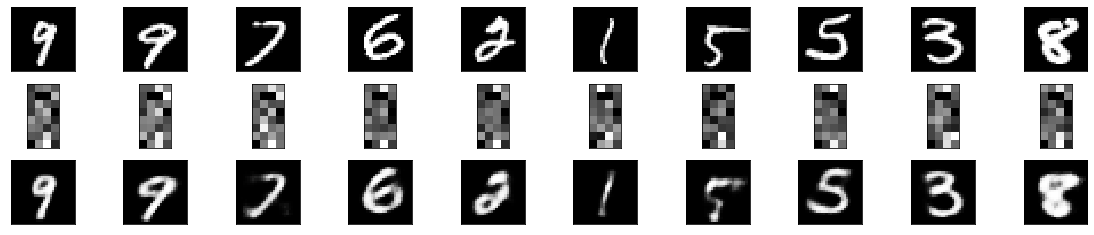

In [0]:
%matplotlib inline
plt.figure(figsize=(40, 4))

# display original images at random
for i, v in enumerate(random.choices(range(len(x_test_im)), k=10)):
    # display original images
    # divided the graph into subplots so that multiple images can be seen at once
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test_im[v].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded images
    ax = plt.subplot(3, 20, 1 + 20 + i)
    plt.imshow(encoded_imgs[v].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 + 1 + i)
    plt.imshow(decoded_imgs[v].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()